<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/Wave2D_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem description

This example illustrates how to model the Interference of waves due to two-point sources corresponding to this experiment  https://www.youtube.com/watch?v=vS2qKx7e9OE.

Denote $u=u(x,t)$ to be the mechanical displacement of a wave at location $x\in\Omega$ and time $t\in [0,T]$, the wave equation for $u$ is

$$\frac{\partial^2 u}{\partial t^2}=c^2\,\Delta u$$
where $c$ is the propagation speed of the wave. 

The initial condition is zero. The equation needs to be subjected to one or several boundary conditions on the boundary $\partial \Omega$. Here two source points need to be imposed.


We first discretize $\Omega$ into triangles and we look for solutions in a space of piece-wise linear functions. This process is automated in FEniCS and we just need to derive the weak forms.

Multiply both sides of the equation with a test function $v$ and integrate it over $\Omega$, we obtain

$$\displaystyle \int\limits_{\Omega} \frac{\partial^2 u}{\partial t^2}\, v\, dx = \int\limits_{\Omega} c^2\,\Delta u\, v\, dx \qquad (1).$$

Apply the Green's first identity, i. e.

$$\displaystyle \int\limits_{\Omega} \Delta u\, v\, dx=\int\limits_{\partial\Omega} \nabla u\cdot \mathbf{n}\, v\, ds - \int\limits_{\Omega} \nabla u \cdot\nabla v\, dx,$$

and notice that the boundary term vanishes due to the Neumann boundary conditions, Eq. (1) is rewritten as
$$\displaystyle \int\limits_{\Omega} \frac{\partial u}{\partial t}\, v\, dx =-\int\limits_{\Omega} \kappa \nabla u \cdot\nabla v\, dx\qquad (2).$$

Now, we discretize the time domain $[0, T]$ into subdomains $[t^{k+1},t^k]_{k=0,N-1}$ where $t^0=0$ and $t^N=T$. 

For any $t\in[t^{k+1},t^k]$, we can approximate the time derivatives 
$$\frac{\partial u(x,t)}{\partial t}\approx\frac{u(x,t^{k+1})-2\,u(x,t^k)+u(x,t^{k-1})}{k^2}=\frac{u^{k+1}-2\,u^k+u^{k-1}}{k^2}$$

Subsitute everything to Eq. (2) we have a time-space discretization of the wave equation

$$\displaystyle \int\limits_{\Omega} \frac{u^{k+1}-2\,u^k+u^{k-1}}{k^2}\, v\, dx =-\int\limits_{\Omega} c^2\, \nabla u^{k+1} \cdot\nabla v\, dx.$$

$$\displaystyle \int\limits_{\Omega} {u^{k+1} v\, dx+\int\limits_{\Omega} k^2\,c^2\, \nabla u^{k+1} \cdot\nabla v\, dx=\int\limits_{\Omega} 2\,u^k-u^{k-1}}\, v\, dx.$$

Let $$a(u^{k+1},v)=\displaystyle \int\limits_{\Omega} u^{k+1} v\, dx+\int\limits_{\Omega} k^2\,c^2\, \nabla u^{k+1} \cdot\nabla v\, dx, \qquad L(v)=\int\limits_{\Omega} 2\,u^k-u^{k-1}\, v\, dx$$
we just need to simply find the solution for the equation
$$a(u^{k+1},v)=L(v)$$
where $a$, and $L$ are known as the bilinear and linear forms in FEM literation.

In FEniCS, the bilinear and linear forms can be simply written as

    a = u*v*dx + k*k*c*c*inner(grad(u), grad(v))*dx
    L = 2*u1*v*dx-u0*v*dx

# Setting a working environment with FEniCS

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


# A wave solver

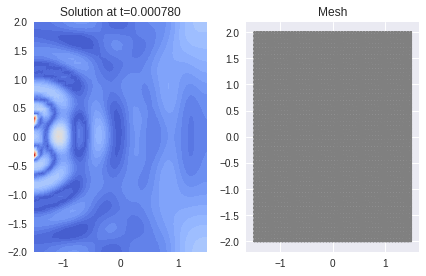

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [0]:
def plot_compact(u, t, stepcounter, QQ, pl, ax): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("Solution at t=%f" % (t)) # Plot norm of velocity
    if t == 0.: plt.axis(G); # plt.colorbar(pp, shrink=0.5); 
    plt.subplot(1, 2, 2);
    if t == 0.: plot(QQ.mesh()); plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

solver = KrylovSolver("gmres")
solver.parameters["relative_tolerance"] = 5e-6
solver.parameters["maximum_iterations"] = 1000
solver.parameters["monitor_convergence"] = True

# This demo adapts an existing code to solve the wave equation
# The orignal code is available at
# https://fenicsproject.org/qa/8883/wave-propagation-from-a-source-point/

XMIN, XMAX = -1.5, 1.5;
YMIN, YMAX = -2.0, 2.0;
G = [XMIN, XMAX, YMIN, YMAX];

c=5000
mesh = RectangleMesh(Point(XMIN, YMIN), Point(XMAX, YMAX),50,50)
V=FunctionSpace(mesh, "Lagrange", 1)

# Time variables
k = 0.000004; t = 0; T = 0.001

  
# Previous and current solution
u1= interpolate(Constant(0.0), V)
u0= interpolate(Constant(0.0), V)

# Variational problem at each time
u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + k*k*c*c*inner(grad(u), grad(v))*dx
L = 2*u1*v*dx-u0*v*dx

A, b = assemble_system(a, L)

pl, ax = None, None; 
stepcounter = 0;
u=Function(V);

while t <= T:
    A, b = assemble_system(a, L, bc)
    delta1 = PointSource(V, Point(-1.5, 0.3), sin(c * 10 * t))
    delta2 = PointSource(V, Point(-1.5, -0.3), sin(c * 10 * t))
    delta1.apply(b)
    delta2.apply(b)
    solver.solve(A, u.vector(), b)
    u0.assign(u1)
    u1.assign(u)
    pl, ax=plot_compact(u1, t, stepcounter, V, pl, ax)
    stepcounter += 1;
    t += dt